### Forecast Revisions with TimeDB

This notebook demonstrates overlapping forecast revisions:
1. Creating multiple forecasts for the same series with different `known_time`
2. Reading all revisions with `read(versions=True)`
3. Visualizing how forecasts evolve over time

In [1]:
import timedb as tb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

tb.delete()
tb.create()

Creating database schema...
✓ Schema created successfully


In [2]:
forecast_series_id = tb.create_series(
    name='forecast',
    unit='MW',
    labels={'type': 'power_forecast', 'model': 'sinus_with_error'},
    description='Forecasted power values with overlapping revisions',
    overlapping=True
)

observation_series_id = tb.create_series(
    name='flat',
    unit='MW',
    labels={'type': 'power_observation'},
    description='Observation power values (ground truth)'
)

for s in tb.series().list_series():
    print(f"  {s['name']}: unit={s['unit']}  overlapping={s['overlapping']}  labels={s['labels']}")

  flat: unit=MW  overlapping=False  labels={'type': 'power_observation'}
  forecast: unit=MW  overlapping=True  labels={'type': 'power_forecast', 'model': 'sinus_with_error'}


## Part 2: Create 4 Forecasts with Shifting Valid Times

Each forecast has a 3-day (72h) horizon starting at its `known_time`, with forecasts issued 1 day apart. Forecast error grows with lead time — early hours are accurate, later hours diverge.

In [3]:
base_valid_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
np.random.seed(0)
observations = np.clip(80 + 40 * np.sin(2 * np.pi * np.arange(144) / 24 - np.pi / 2) + np.random.normal(0, 3, 144), 0, None)

for i in range(4):
    known_time = base_valid_time + timedelta(days=i)
    np.random.seed(42 + i)
    forecast = np.round(observations[i*24:i*24+72] + np.random.normal(0, 1 + 0.3 * np.arange(72)), 2)
    tb.series("forecast").where(type='power_forecast', model='sinus_with_error').insert(
        df=pd.DataFrame({"valid_time": [known_time + timedelta(hours=j) for j in range(72)], "value": forecast}),
        known_time=known_time)

tb.series("flat").where(type='power_observation').insert(
    df=pd.DataFrame({"valid_time": [base_valid_time + timedelta(hours=i) for i in range(144)], "value": np.round(observations, 2)}))
print("Inserted 4 forecast batches + 144 hours of observations")

Inserted 4 forecast batches + 144 hours of observations


## Part 3: Read Latest Forecast Revisions

Now we'll read back the latest forecast revisions using `td.read()`.
This returns the latest forecast for each valid_time (most recent based on known_time) in a single query.
The observations are recorded in a separate series.

In [4]:
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(hours=144)

# Read latest forecast and observations
df_forecast = tb.series("forecast").where(
    type='power_forecast', model='sinus_with_error'
).read(start_valid=start_valid, end_valid=end_valid)

df_observation = tb.series("flat").where(
    type='power_observation'
).read(start_valid=start_valid, end_valid=end_valid)

df_flat = pd.DataFrame({
    'forecast': df_forecast['value'],
    'observation': df_observation['value']
}, index=df_forecast.index)

df_flat.head(10)

,forecast,observation
valid_time,,
2025-01-01 00:00:00+00:00,45.79,45.29
2025-01-01 01:00:00+00:00,42.38,42.56
2025-01-01 02:00:00+00:00,49.33,48.30
2025-01-01 03:00:00+00:00,61.33,58.44
2025-01-01 04:00:00+00:00,65.09,65.60
2025-01-01 05:00:00+00:00,66.13,66.72
2025-01-01 06:00:00+00:00,87.27,82.85
2025-01-01 07:00:00+00:00,92.28,89.90
2025-01-01 08:00:00+00:00,98.09,99.69


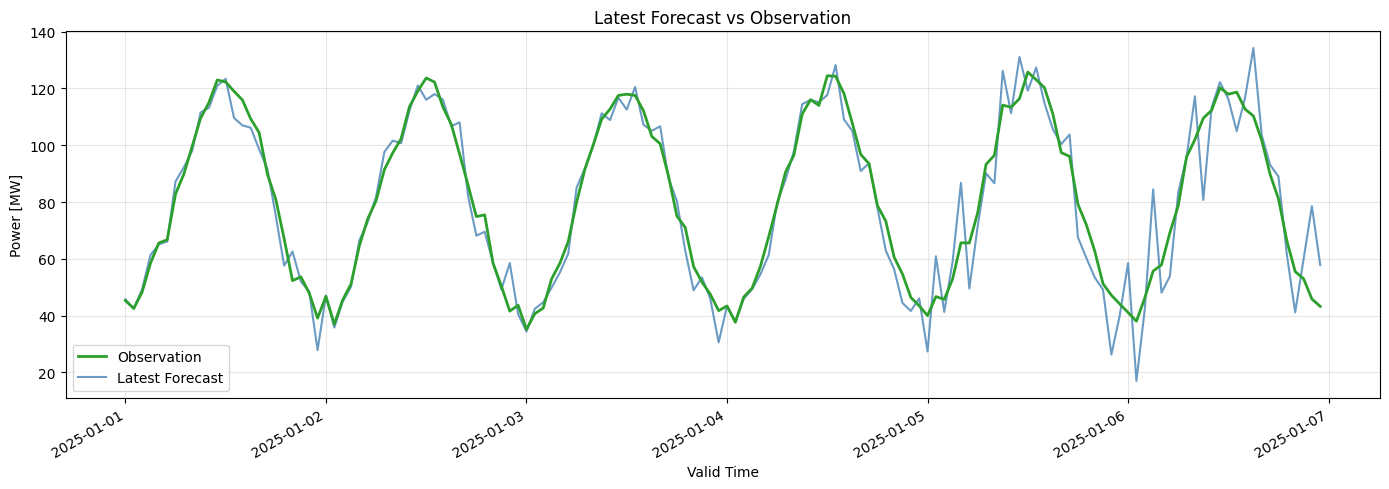

In [5]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df_flat.index, df_flat['observation'].astype(float), linewidth=2, color='#2ca02c', label='Observation', zorder=5)
ax.plot(df_flat.index, df_flat['forecast'].astype(float), linewidth=1.5, color='steelblue', label='Latest Forecast', alpha=0.8)

ax.set_xlabel('Valid Time')
ax.set_ylabel('Power [MW]')
ax.set_title('Latest Forecast vs Observation')
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Part 4: Read All Forecast Revisions (Overlapping Mode)

Now let's read all forecast revisions using `.read(versions=True)` on the series collection.
This returns all forecasts with both `known_time` and `valid_time`, showing how
forecasts evolve over time. This is useful for analyzing forecast revisions and backtesting.

In [6]:
# Read all forecast revisions with (known_time, valid_time) multi-index
df_forecast_overlapping = tb.series("forecast").where(
    type='power_forecast', model='sinus_with_error'
).read(start_valid=start_valid, end_valid=end_valid, versions=True)

# Read observations (flat)
df_observation_overlapping = tb.series("flat").where(
    type='power_observation'
).read(start_valid=start_valid, end_valid=end_valid)

print(f"Forecast: {df_forecast_overlapping.shape}  index={df_forecast_overlapping.index.names}")
print(f"Observation:   {df_observation_overlapping.shape}  index={df_observation_overlapping.index.name}")
print()
df_forecast_overlapping.head(6)

Forecast: (288, 1)  index=['known_time', 'valid_time']
Observation:   (144, 1)  index=valid_time



value
known_time                valid_time                      
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00  45.79
                          2025-01-01 01:00:00+00:00  42.38
                          2025-01-01 02:00:00+00:00  49.33
                          2025-01-01 03:00:00+00:00  61.33
                          2025-01-01 04:00:00+00:00  65.09
                          2025-01-01 05:00:00+00:00  66.13

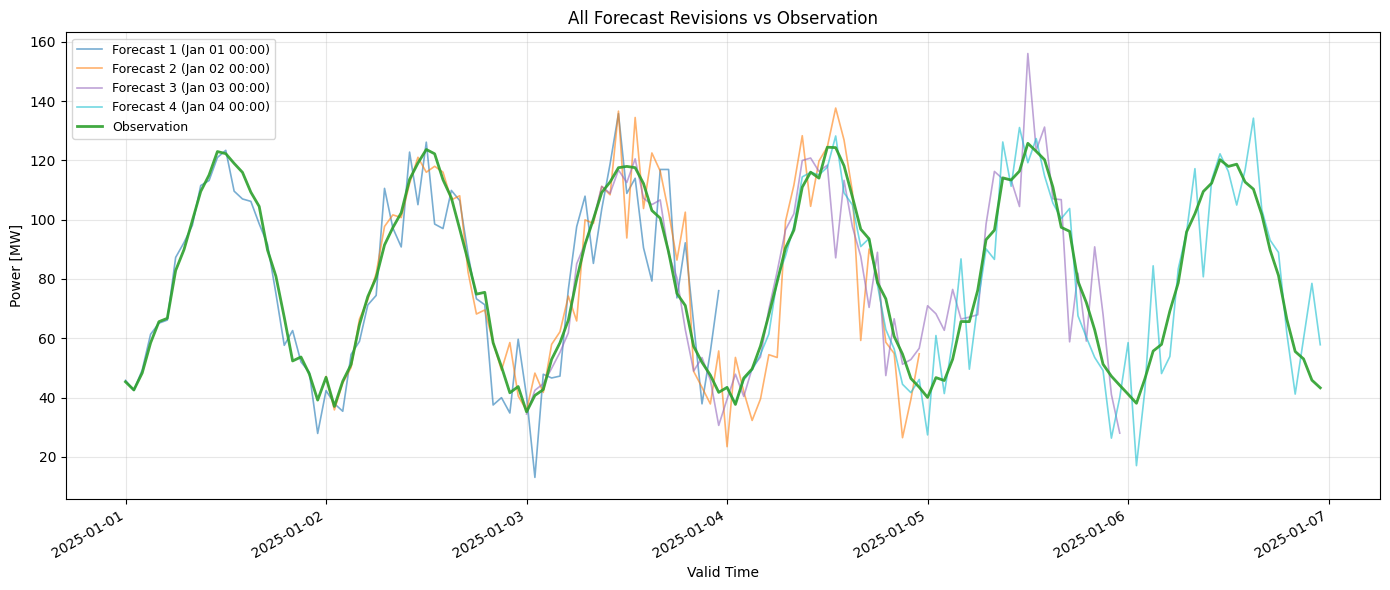

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each forecast revision in a distinct color
unique_known_times = df_forecast_overlapping.index.get_level_values("known_time").unique()
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#17becf']

for idx, known_time in enumerate(unique_known_times):
    forecast_data = df_forecast_overlapping.xs(known_time, level="known_time")
    values = forecast_data['value'].astype(float)
    label = f"Forecast {idx+1} ({known_time.strftime('%b %d %H:%M')})"
    ax.plot(forecast_data.index, values, linewidth=1.2,
            color=colors[idx % len(colors)], alpha=0.6, label=label)

# Plot observations on top
observation_vals = df_observation_overlapping['value'].astype(float)
ax.plot(df_observation_overlapping.index, observation_vals, linewidth=2,
        color='#2ca02c', label='Observation', alpha=0.9, zorder=10)

ax.set_xlabel('Valid Time')
ax.set_ylabel('Power [MW]')
ax.set_title('All Forecast Revisions vs Observation')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Summary

- `known_time` = when the forecast was made; `valid_time` = what it predicts
- `overlapping=True` enables versioned storage with `known_time` tracking
- `read()` returns the latest forecast (one value per `valid_time`)
- `read(versions=True)` returns all revisions with a `(known_time, valid_time)` multi-index